<a href="https://colab.research.google.com/github/hwangsae91/project_so/blob/master/exploration/221018/%5BExp_10%5D20221018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# google colab전용
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# exploration 10번째 과제
@ 황한용(3기/쏘카)

## 라이브러리 선언

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import string # 구두점 정규화 표현식
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

`tensorflow.keras.preprocessing.sequence.pad_sequences`는 모듈 위치가 변경되었으므로
`tf.keras.utils.pad_sequences`로 변경<br>

## 상수선언

In [ ]:
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/data/translator_seq2seq" # 데이터 기본경로
DATA_PATH  = BASE_PATH + "/data/fra.txt" # 사전 기본

SOS_TOKEN = '<sos>' # 문장 시작토큰
EOS_TOKEN = '<eos>' # 문장 끝 토큰

MAX_SAMPLE_LEN = 88000 # 최대 단어갯수
VALID_LEN = 8000 # 검증할 문장의 갯수
PUNCTUATION_REGEX = r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]' # 정규화
FRENCH_WHITESPACE = r'[\xa0\u202f\u2009]' # whitespace 정규화(1/4 whitespace 등의 대응)
FRENCH_APOSTROPHE = r"’" # 프랑스어 '
FRENCH_DOUBLE_COMMA = r"'<<|>>'" # 프랑스어 "
FRENCE_MINUS_REGEX = r"\—" # 프랑스어 -

HIDDEN_STATE_NUM = 256 # hidden state의 노드수
EARLY_STOPPING = EarlyStopping(monitor="val_acc", patience=3)

fit_kwargs = {
    "epochs":50 # epoch 횟수
    , "batch_size":512
    , "callbacks":EARLY_STOPPING
    , "validation_data": None # 추후 추가예정
    , "shuffle" : True # epoch당 셔플을 할지의 여부
    , "verbose":1
}

영어의 경우는 `string.punctuation`의 구두점을 활용하여 만들었다.<br>
프랑스어의 경우는 문법에 따라 1/8, 1/4, 1/2 `whitespace`를 표준`whitespace`로 변경하였으며<br>
`'`, `"`, `-` 또한 표준으로 변경하였다.<br>
알파벳의 악쌍(악센트, 성조)은 단어의 의미를 결정하는 요소이므로 제거하지 않았다.

## 메인

### 전처리

In [ ]:
lines = pd.read_csv(DATA_PATH, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력
lines.pop('cc')
lines = lines.head(MAX_SAMPLE_LEN)

전체 샘플의 수 : 197463


데이터에 대한 설명은 아래와 같다.</br>
- eng: 영어문장
- fra: 영어 문장에 해당되는 프랑스 문장
- cc: 저작권 정보

저작권 정보는 데이터 분석에 사용되지 않으므로 로드하지 않았다.

In [ ]:
# 구두점(Punctuation)을 단어와 분리
# 프랑스 문법에만 존재하는 whitespace -> 표준 whitespace로 변경
lines["fra"] = lines["fra"].str.replace(FRENCH_WHITESPACE, r' ', regex=True)
#프랑스 문법에만 존재하는 ’를 '로 변경
lines["fra"] = lines["fra"].str.replace(FRENCH_APOSTROPHE, r"'", regex=True)
# 프랑스 문법에만 존재하는 <<, >>를 "로 변경
lines["fra"] = lines["fra"].str.replace(FRENCH_DOUBLE_COMMA, r'"', regex=True)
# 프랑스 문법에만 존재하는 —를 -로 변경
lines["fra"] = lines["fra"].str.replace(FRENCE_MINUS_REGEX, r"-", regex=True)

# 구분점에 whitespace를 지음
lines["fra"] = lines["fra"].str.replace(PUNCTUATION_REGEX, r' \g<0> ', regex=True).replace(' +', ' ', regex=True).str.strip()
lines["eng"] = lines["eng"].str.replace(PUNCTUATION_REGEX, r' \g<0> ', regex=True).replace(' +', ' ', regex=True).str.strip()
lines["fra"] = lines["fra"].str.replace(' +', ' ', regex=True)
lines["eng"] = lines["eng"].str.replace(' +', ' ', regex=True)

lines["fra_decoder_input"] = f'{SOS_TOKEN} '+ lines["fra"]
lines["fra_decoder_target"] = lines["fra"] + f' {EOS_TOKEN}'
lines["fra"] = f'{SOS_TOKEN} '+ lines["fra"] + f' {EOS_TOKEN}' # 양옆에 문장의 시작과 끝의 테그를 붙인다.

lines["eng"] = lines["eng"].str.split()

lines["fra"] = lines["fra"].str.split()
lines["fra_decoder_input"] = lines["fra_decoder_input"].str.split()
lines["fra_decoder_target"] = lines["fra_decoder_target"].str.split()

eng_tokenizer = Tokenizer(filters="")  # 문자 단위로 Tokenizer를 생성 
eng_tokenizer.fit_on_texts(lines["eng"])
encoder_input = eng_tokenizer.texts_to_sequences(lines["eng"])

fra_tokenizer = Tokenizer(filters="")
fra_tokenizer.fit_on_texts(lines["fra"])

decoder_input = fra_tokenizer.texts_to_sequences(lines["fra_decoder_input"])
decoder_target = fra_tokenizer.texts_to_sequences(lines["fra_decoder_target"])

eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

max_eng_seq_len = max(map(len, encoder_input))
max_fra_seq_len = max(map(len, decoder_input))
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 단어장의 크기 : 8329
프랑스어 단어장의 크기 : 14702
영어 시퀀스의 최대 길이 12
프랑스어 시퀀스의 최대 길이 19


영어문장와 프랑스문장를 각각 tokenize한 뒤<br>
단어 사전의크기, 한 문장의 최대 단어 갯수를 확인<br>
이 데이터는 후에 padding에 사용할 예정이다.<br>
문장의 끝 토큰이 제거된 input과<br>
문장의 시작 토큰이 제거된 output을 각각 데이터 프레임에서 생산하였으며<br>
이번에는 구두점도 임배딩에 필요하므로 필터옵션을 통해 없어지지 않도록 설정하였다.<br>

In [ ]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (88000, 12)
프랑스어 입력데이터의 크기(shape) : (88000, 19)
프랑스어 출력데이터의 크기(shape) : (88000, 19)


각 언어의 최대 단어갯수에 맞춰 padding을 생성하였다.<br>
(`문장의 갯수`,`각 언어의 문장당 단어 최대갯수`)모양의 데이터가 생성되었다.


In [ ]:
shuffle_idx  = np.arange(MAX_SAMPLE_LEN)
np.random.shuffle(shuffle_idx)

encoder_input = encoder_input[shuffle_idx]
decoder_input = decoder_input[shuffle_idx]
decoder_target = decoder_target[shuffle_idx]

print(encoder_input[3])
print(decoder_input[3])
print(decoder_target[3])

encoder_input_train = encoder_input[:-VALID_LEN]
decoder_input_train = decoder_input[:-VALID_LEN]
decoder_target_train = decoder_target[:-VALID_LEN]

encoder_input_test = encoder_input[-VALID_LEN:]
decoder_input_test = decoder_input[-VALID_LEN:]
decoder_target_test = decoder_target[-VALID_LEN:]

[ 230   28 2615    1    0    0    0    0    0    0    0    0]
[   1 1227   89 4927    3    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[1227   89 4927    3    2    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]


과적합 방지를 위해 학습과 점증을 10:1비율로 나누었다.<br>
문장셈플은 인덱스를 렌덤값을 통해 섞어서 순서를 바꿨으며<br>
임의로 하나의 값을 뽑았을 시<br>
`decoder_input`과 `decoder_target`의 값은 `<sos>`, `<eos>`의 차이이므로 올바르게 섞인것을 확인할 수 있다.<br>

### 모델 설계

#### running rate가 기본값인 모델

In [ ]:
encoder_inputs = Input(shape=(None,))
encoder_embadding = Embedding(eng_vocab_size, HIDDEN_STATE_NUM)
encoder_masking = Masking(mask_value=0.0)(encoder_embadding(encoder_inputs))
encoder_lstm = LSTM(units=HIDDEN_STATE_NUM, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_masking)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, ))
decoder_embadding = Embedding(fra_vocab_size, HIDDEN_STATE_NUM)
decoder_masking = Masking(mask_value=0.0)(decoder_embadding(decoder_inputs))
decoder_lstm = LSTM(units=HIDDEN_STATE_NUM, return_sequences = True, return_state=True)
decoder_outputs, _, _= decoder_lstm(decoder_masking, initial_state = encoder_states)

decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name="seq2seq_model")
model.compile(
    optimizer=tf.keras.optimizers.Adam()
    , loss="sparse_categorical_crossentropy", metrics=['acc']
)
model.summary()

Model: "seq2seq_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    2132224     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    3763712     ['input_2[0][0]']                
                                                                                      

encorder는 영어를 프랑스어로 번역하기 위한 레이어이므로<br>
decorder의 input에 맞게 모델을 구성하였으며<br>
one-hot 인코딩을 하지 않은 상태이므로 `sparse_categorical_crossentropy`로 설정하였다.

#### running rate가 높은 모델(overfitting이 될 가능성이 있음)

In [ ]:
overfit_encoder_inputs = Input(shape=(None,))
overfit_encoder_embadding = Embedding(eng_vocab_size, HIDDEN_STATE_NUM)
overfit_encoder_masking = Masking(mask_value=0.0)(overfit_encoder_embadding(overfit_encoder_inputs))
overfit_encoder_lstm = LSTM(units=HIDDEN_STATE_NUM, return_state = True)
overfit_encoder_outputs, overfit_state_h, overfit_state_c = overfit_encoder_lstm(overfit_encoder_masking)
overfit_encoder_states = [overfit_state_h, overfit_state_c]

overfit_decoder_inputs = Input(shape=(None, ))
overfit_decoder_embadding = Embedding(fra_vocab_size, HIDDEN_STATE_NUM)
overfit_decoder_masking = Masking(mask_value=0.0)(overfit_decoder_embadding(overfit_decoder_inputs))
overfit_decoder_lstm = LSTM(units=HIDDEN_STATE_NUM, return_sequences = True, return_state=True)
overfit_decoder_outputs, _, _= overfit_decoder_lstm(overfit_decoder_masking, initial_state = overfit_encoder_states)

overfit_decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
overfit_decoder_outputs = overfit_decoder_softmax_layer(overfit_decoder_outputs)

overfit_model = Model([overfit_encoder_inputs, overfit_decoder_inputs], overfit_decoder_outputs, name="overfit_seq2seq_model")
overfit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005)
    , loss="sparse_categorical_crossentropy", metrics=['acc']
)
overfit_model.summary()

Model: "overfit_seq2seq_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 256)    2132224     ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 256)    3763712     ['input_4[0][0]']                
                                                                              

running rate를 기존의 값인 0.001보다 5배 높혔다.

### 학습

Epoch 1/50
157/157 [==============================] - 35s 170ms/step - loss: 2.9128 - acc: 0.6106 - val_loss: 2.0677 - val_acc: 0.6485
Epoch 2/50
157/157 [==============================] - 25s 161ms/step - loss: 1.8320 - acc: 0.7134 - val_loss: 1.6623 - val_acc: 0.7383
Epoch 3/50
157/157 [==============================] - 25s 157ms/step - loss: 1.5353 - acc: 0.7519 - val_loss: 1.4689 - val_acc: 0.7639
Epoch 4/50
157/157 [==============================] - 24s 155ms/step - loss: 1.3880 - acc: 0.7730 - val_loss: 1.3584 - val_acc: 0.7772
Epoch 5/50
157/157 [==============================] - 25s 158ms/step - loss: 1.2734 - acc: 0.7871 - val_loss: 1.2497 - val_acc: 0.7933
Epoch 6/50
157/157 [==============================] - 25s 157ms/step - loss: 1.1664 - acc: 0.8026 - val_loss: 1.1637 - val_acc: 0.8049
Epoch 7/50
157/157 [==============================] - 25s 157ms/step - loss: 1.0774 - acc: 0.8132 - val_loss: 1.0900 - val_acc: 0.8146
Epoch 8/50
157/157 [==============================] - 2

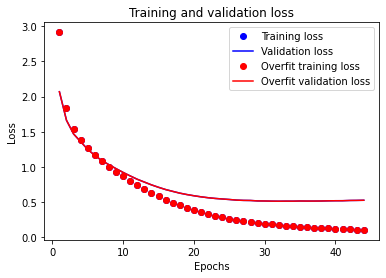

In [ ]:
fit_kwargs["validation_data"] = ([encoder_input_test, decoder_input_test], decoder_target_test)

history_dict = model.fit(
                         x=[encoder_input_train, decoder_input_train]
                         , y=decoder_target_train
                         , **fit_kwargs).history

overfit_history_dict = overfit_model.fit(
                            x=[encoder_input_train, decoder_input_train]
                            , y=decoder_target_train
                            , **fit_kwargs).history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
overfit_loss = overfit_history_dict['loss']
overfit_val_loss = overfit_history_dict['val_loss']

epoch = range(1, len(loss) + 1)

plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.plot(epoch, loss, 'ro', label='Overfit training loss')
plt.plot(epoch, val_loss, 'r', label='Overfit validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

입력값은 똑같이 적용하였으며<br>
여러번의 실험의 결과 validation accuracy의 값이 90%이상이면<br>
대체로 비슷한 문장이 나오므로 early stopping의 기준으로 잡았다.<br>
학습결과
- running rate에 상관없이 둘다 똑같은 그래프의 모양이다.
- epoch이 8 이후부터 train loss, validation loss의 차이가 드러나며<br>
validation loss는 약 epoch 20을 기점으로 내려가지 않는다.

라는 결과를 알 수 있다.

### 검증


In [ ]:
###################################################<<<nomal>>>##################################################################

encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(HIDDEN_STATE_NUM,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(HIDDEN_STATE_NUM,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embadding_val = decoder_embadding(decoder_inputs)

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs_val, state_h, state_c = decoder_lstm(decoder_embadding_val, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states_val = [state_h, state_c]

decoder_outputs_val = decoder_softmax_layer(decoder_outputs_val)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs_val] + decoder_states_val, name="teaching_model")
decoder_model.summary()

###################################################<<<overfit>>>##################################################################

overfit_encoder_model = Model(inputs = overfit_encoder_inputs, outputs = overfit_encoder_states)
overfit_encoder_model.summary()

# 이전 time step의 hidden state를 저장하는 텐서
overfit_decoder_state_input_h = Input(shape=(HIDDEN_STATE_NUM,))
# 이전 time step의 cell state를 저장하는 텐서
overfit_decoder_state_input_c = Input(shape=(HIDDEN_STATE_NUM,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
overfit_decoder_states_inputs = [overfit_decoder_state_input_h, overfit_decoder_state_input_c]

overfit_decoder_embadding_val = overfit_decoder_embadding(overfit_decoder_inputs)

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
overfit_decoder_outputs_val, overfit_state_h, overfit_state_c = overfit_decoder_lstm(overfit_decoder_embadding_val, initial_state = overfit_decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
overfit_decoder_states_val = [overfit_state_h, overfit_state_c]

overfit_decoder_outputs_val = overfit_decoder_softmax_layer(overfit_decoder_outputs_val)
overfit_decoder_model = Model(inputs=[overfit_decoder_inputs] + overfit_decoder_states_inputs, outputs=[overfit_decoder_outputs_val] + overfit_decoder_states_val, name="overfit_teaching_model")
overfit_decoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         2132224   
                                                                 
 masking (Masking)           (None, None, 256)         0         
                                                                 
 lstm (LSTM)                 [(None, 256),             525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 2,657,536
Trainable params: 2,657,536
Non-trainable params: 0
_________________________________________________________________
Model: "teaching_model"
___________________________

두 model에 맞는 teaching forcing을 구현하였다.

In [ ]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

단어 -> 인덱스, 인덱스 -> 단어에 해당하는 데이터 생성

In [ ]:
def decode_sequence(input_seq, encoder_model, decoder_model):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = fra2idx[SOS_TOKEN]

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += " " + sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == EOS_TOKEN or
           len(decoded_sentence) > fit_kwargs["epochs"]):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

예제에 있던 코드를 가져왔으며 ont-hot vector에 해당하는 부분을 입/출력값에 맞게 조정하였다.<br>
이번에는 각 모델의 학습에 따른 출력값을 비교가 필요하므로<br>
각 모델을 파라미터로 받아 번역하는 함수로 수정하였다.<br>

In [ ]:
sample = 15
input_seq = encoder_input_train[sample: sample + 1]

print("-" * 35)

print("입력문장 :", "".join([
        idx2eng[encoded_word] + " "
        for encoded_word in encoder_input_train[sample]
        if encoded_word != 0
    ])
)
print("정답문장 :",  "".join([
      idx2fra[encoded_word] + " "
      for encoded_word in decoder_input_train[sample]
      if encoded_word != 0 and encoded_word != fra2idx[SOS_TOKEN] and encoded_word != fra2idx[EOS_TOKEN]
  ])
)

print("과적합이 안된 모델")
print("번역문장 :",decode_sequence(input_seq, encoder_model, decoder_model)[1:-5])
print("과적합된 모델")
print("번역문장 :",decode_sequence(input_seq, overfit_encoder_model, overfit_decoder_model)[1:-5])

print("-" * 35)

input_seq = encoder_input_test[sample: sample + 1]

print("-" * 35)

print("입력문장 :", "".join([
        idx2eng[encoded_word] + " "
        for encoded_word in encoder_input_test[sample]
        if encoded_word != 0
    ])
)
print("정답문장 :",  "".join([
      idx2fra[encoded_word] + " "
      for encoded_word in decoder_input_test[sample]
      if encoded_word != 0 and encoded_word != fra2idx[SOS_TOKEN] and encoded_word != fra2idx[EOS_TOKEN]
  ])
)

print("과적합이 안된 모델")
print("번역문장 :",decode_sequence(input_seq, encoder_model, decoder_model)[1:-5])
print("과적합된 모델")
print("번역문장 :",decode_sequence(input_seq, overfit_encoder_model, overfit_decoder_model)[1:-5])

print("-" * 35)

-----------------------------------
입력문장 : i told tom i hated him . 
정답문장 : j ' ai dit à tom que je le détestais . 
과적합이 안된 모델
1/1 [==============================] - 0s 15ms/step
번역문장 : j ' ai dit à tom que je le détestais . 
과적합된 모델
1/1 [==============================] - 0s 14ms/step
번역문장 : j ' ai dit à tom que je le détestais . 
-----------------------------------
-----------------------------------
입력문장 : i ' m not here to fight . 
정답문장 : je ne suis pas là pour me bagarrer . 
과적합이 안된 모델
1/1 [==============================] - 0s 15ms/step
번역문장 : je ne suis pas là pour me battre . 
과적합된 모델
1/1 [==============================] - 0s 14ms/step
번역문장 : je ne suis pas là pour me battre . 
-----------------------------------


train의 데이터, test의 데이터에서 랜덤으로 셈플을 추출했으며<br>
train의 경우에는 정답과 똑같은 문장이 나와서 번역기를 통해 해석을 하지 않았다.<br>
test의 경우에는 마지막 단어가 다르므로 번역기를 통해 해석을 하였다.<br>
두 문장이 똑같으므로 결과사진을 1장만 첨부하였으며 내용은 아래와 같다.<br>
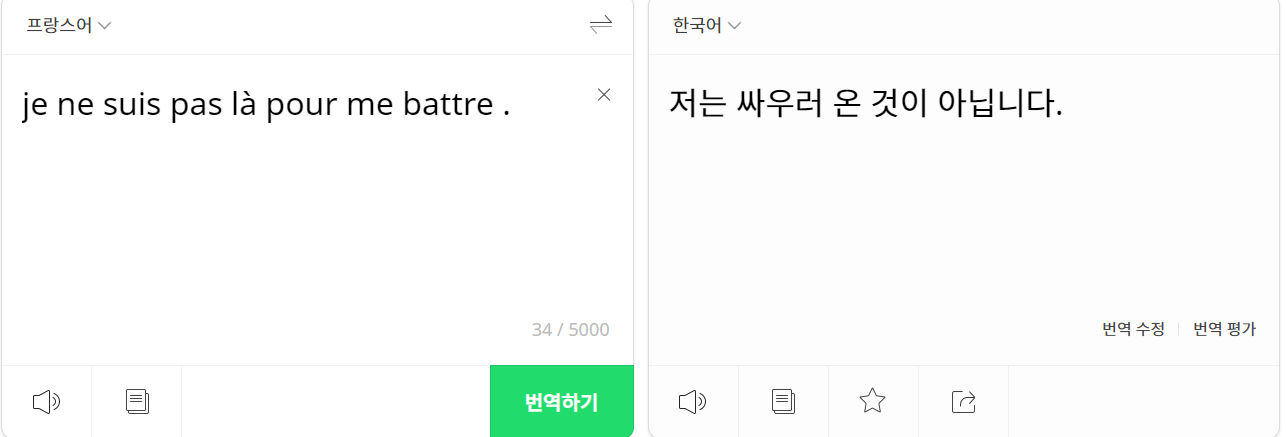
프랑스 원문의 1인칭 단수 구어 `bagarrer`가 1인칭 단수`battre`로 변경되었으며<br>두 단어 동등한 의미미므로 정확히 해석했다고 할 수 있다.<br>
※ 위에서 전처리중 문장을 랜덤으로 섞는 코드로 인하여 인덱스가 고정값이여도<br>
구동할때마다 선택하는 문장이 달라진다.

### 회고


이전에 여러번 학습의 경험으로 통해 과학습이 된 번역기가 평균적으로 결과가 높게 나와서 과학습이 된 모델이 정확한 번역을 한다는 가정을 하였지만 early stopping을 적용하게 됨으로써 두 모델 다 좋은 결과를 얻게되었다.<br>
early stopping의 기능을 잊어먹은 대가로 3일정도 시간을 소비한게 안타까울 따름이다.